<div>
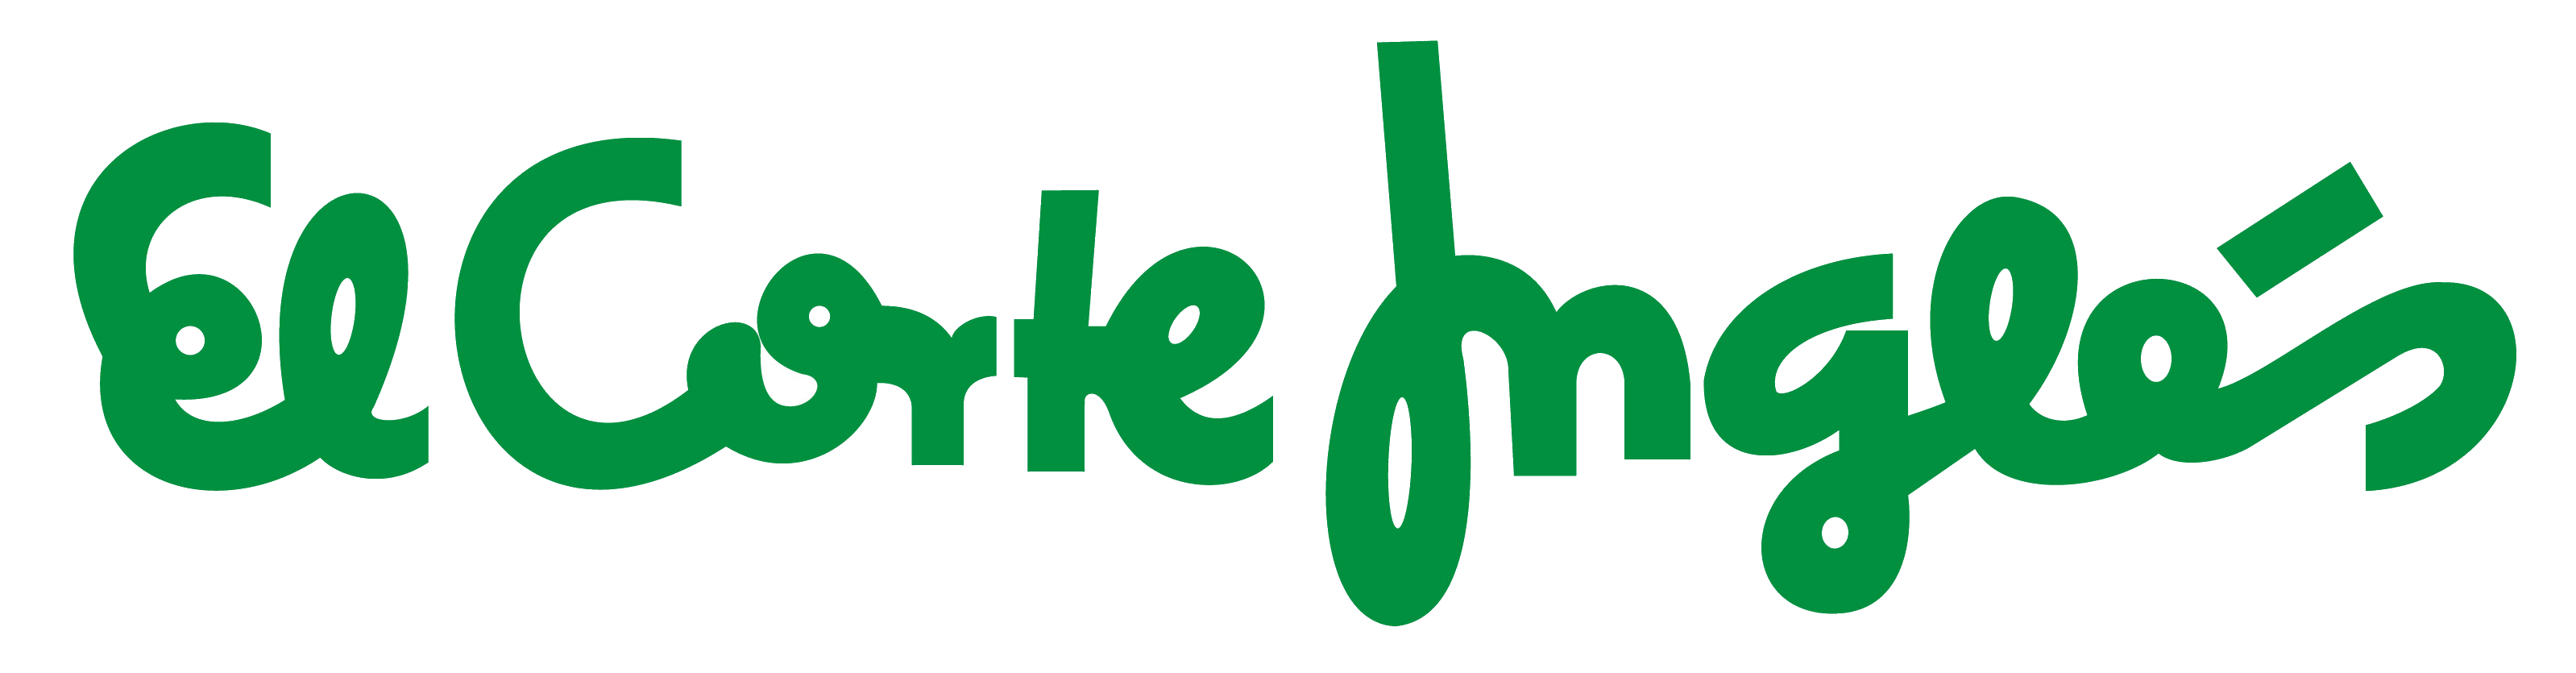
</div>

# Localización de centros ElCorteInglés

## Resumen:
Partiendo de la página de ECI con la lista de todos los centros en España sacaremos una lista con todas las url de esos centros para posteriormente entrar en cada uno y sacar la información y localización geográfica de los centros. Incluiremos toda la información en un dataframe que luego usaremos para visualizar los centros en un mapa interactivo.

### Paso 1:

Primero necesitamos extraer la lista con todas las url de los centros ElCorteInglés que hay en España (y Portugal).

La página desde la que iniciaremos la búsqueda es: https://www.elcorteingles.es/centroscomerciales/es/eci/centros

### Paso 2:

Una vez tenemos las url de todos los centros entraremos en todas las páginas para sacar la información de los centros (Nombre, Dirección, Teléfono, localización) y guardaremos esos datos en un DataFrame.

### Paso 3:

Partiendo del DataFrame anterior visualizaremos los datos con folium en un mapa interactivo que muestre la localización de los centros y toda la información a modo de popup.

### Paso 4:

Como ampliación del proyecto se propone añadir un sistema de búsqueda de los centros más cercanos mediante el código postal. El usuario introduce el CP y el sistema muestra un mapa de los centros más cercamos, así como la distancia (en km) de cada uno a este punto.


In [1]:
import numpy as np
import pandas as pd

import requests
from bs4 import BeautifulSoup

from time import sleep

from selenium import webdriver # Chrome
import helium

import folium
from folium import plugins

In [2]:
#Paso 1: Obtengo las url de todos los centros

url_inicio = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros?page=1"

url_fin = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros?page=5"

url_list = list()

for i in range(1, 6):
    
    url = f"https://www.elcorteingles.es/centroscomerciales/es/eci/centros?page={i}"
    
    session = requests.Session()

    session.headers["User-Agent"] ="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"

    response = session.get(url)

    soup = BeautifulSoup(response.text, "html.parser")
    
    links = [s["href"] for s in soup.find_all("a", class_ = "service")] #Se muestran sólo las extensiones
     
    url_list.extend(links)
    
    sleep(1)

#Paso 2: Obtengo la informacion de todos los centros

centros = list()
imagenes = list()
ciudades = list()
direcciones = list()
telefonos = list()
coordenadas = list()
webs = list()

for url_extension in url_list:

    url_body = "https://www.elcorteingles.es"

    url = f"https://www.elcorteingles.es{url_extension}"
    
    session = requests.Session()

    session.headers["User-Agent"] ="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"

    response = session.get(url)

    soup = BeautifulSoup(response.text, "html.parser")

    try:
        centro = soup.find("h1", class_ = "text-center").text.replace("Centro Comercial de ", "")
    except:
        centro = np.nan

    try:
        imagen_extension = soup.find("img", alt="Imagen principal de la tienda")["src"]
        imagen = f"https://www.elcorteingles.es{imagen_extension}"
    except:
        imagen = np.nan

    try:
        ciudad = soup.find("p", class_ = "text-center subtitle").text
    except:
        ciudad = np.nan

    try:
        direccion = soup.find("div", class_ = "building").find("dd").text
    except:
        direccion = np.nan

    try:
        telefono = soup.find("a", class_ = "phone").text.strip()
    except:
        telefono = np.nan

    try:
        lat = soup.find("div", class_ = "localization").find("script").text.split("lat:")[1].split(",")[0]
        lng = soup.find("div", class_ = "localization").find("script").text.split("lng:")[1].split("}")[0]
        coordenada = [lat, lng]
    except:
        coordenada = np.nan
        
    centros.append(centro)
    imagenes.append(imagen)
    ciudades.append(ciudad)
    direcciones.append(direccion)
    telefonos.append(telefono)
    coordenadas.append(coordenada)
    webs.append(url)
    
    sleep(1)

df_ECI = pd.DataFrame()

df_ECI["Centro"] = centros
df_ECI["Ciudad"] = ciudades
df_ECI["Dirección"] = direcciones
df_ECI["Teléfono"] = telefonos
df_ECI["Coordenadas"] = coordenadas
df_ECI["Imagen"] = imagenes
df_ECI["Sitio Web"] = webs
    
display(df_ECI)

#Paso 3: Representar los centros en el mapa

mapa_ECI = folium.Map(location = [40.4637, -3.7492], zoom_start = 6, tiles = "CartoDB Positron")

coordenadas = df_ECI["Coordenadas"].values

#Convierto los datos de la lista a float

for enumi, i in enumerate(coordenadas):
    for enumj, j in enumerate(i):
        coordenadas[enumi][enumj] = float(j)
        
# Creamos el mapa

for i in range(len(df_ECI)):

    coord = coordenadas[i]
    centro = df_ECI.iloc[i]["Centro"]
    ciudad = df_ECI.iloc[i]["Ciudad"]
    direccion = df_ECI.iloc[i]["Dirección"]
    telefono = df_ECI.iloc[i]["Teléfono"]
    imagen = df_ECI.iloc[i]["Imagen"]
    web = df_ECI.iloc[i]["Sitio Web"] 

    html=f"""
        <div style="text-align: center;">
            <img class="center-image" src="{imagen}" alt="Imagen principal del centro" style="width:150px;height:auto;">
        </div>
        <h3 style="font-family:Verdana;font-size:14px;"">{centro}</h3>
        <h4 style="font-family:Verdana;font-size:12px;">{ciudad}</h4>       
        <p style="font-family:Verdana;font-size:10px;"><b>Direccion </b>{direccion}</p>
        <p style="font-family:Verdana;font-size:10px;"><b>Teléfono </b>{telefono}</p>
        <p style="font-family:Verdana;font-size:10px;">Ir al <a href="{web}" target = "_blank">sitio web </a></p>
         """

    icon = folium.features.CustomIcon("https://www.elcorteingles.es/recursos/informacioncorporativa/img/portal/2017/07/06/el-corte-ingles-triangulo.png", icon_size=(50,25))

    iframe = folium.IFrame(html = html, width = 200, height = 200)

    popup = folium.Popup(iframe, max_width=200)

    folium.Marker(location = coord, icon=icon, popup = popup).add_to(mapa_ECI)

mapa_ECI.save("mapa_ECI.html")

mapa_ECI

#Más iconos de la cadena ECI en: https://www.elcorteingles.es/informacioncorporativa/es/comunicacion/identidad-corporativa/

,Centro,Ciudad,Dirección,Teléfono,Coordenadas,Imagen,Sitio Web
0,El Corte Inglés Bahía de Algeciras,Cádiz,"Pº Juan Pérez Arriete, s/n, 11204 Algeciras, C...",956 582 800,"[36.1408845, -5.4473239]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
1,El Corte Inglés El Ejido,Almería,"Pº Pedro Ponce, s/n, 04700, El Ejido, Almería",950 542 000,"[36.7728460, -2.8045970]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
2,El Corte Inglés Bahía de Cádiz,Cádiz,"Avda. de las Cortes de Cádiz, 1, 11012 Cádiz",956 297 100,"[36.5220610, -6.2780100]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
3,El Corte Inglés Ronda de los Tejares,Córdoba,"Avda. Ronda de los Tejares, 30, 14008 Córdoba",957 222 881,"[37.8874941, -4.7830877]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
4,El Corte Inglés Ronda de Córdoba,Córdoba,"Ronda de Poniente-Ctra. Sta. Mª de Trassiera, ...",957 224 949,"[37.8949600, -4.8081200]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
...,...,...,...,...,...,...,...
80,El Corte Inglés Genil,Granada,"Carrera de la Virgen, 20-22, 18005 Granada, Gr...",958 223 240,"[37.1709030, -3.5976180]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
81,El Corte Inglés Preciados-Callao,Madrid,"C/ Preciados, 3, 28013 Madrid, Madrid",91 379 80 00,"[40.4182774, -3.7051650]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
82,El Corte Inglés Gaia-Oporto,Porto,"Avda. da República, 1435, 4430-999 Vila Nova d...",(+351) 223 781 400,"[41.1260000, -8.6050000]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...
83,El Corte Inglés Lisboa,Lisboa,"Avda. António Augusto de Aguiar, 31, 1069-413 ...",(+351) 213 711 700,"[38.7330000, -9.1540000]",https://www.elcorteingles.es/centroscomerciale...,https://www.elcorteingles.es/centroscomerciale...


In [3]:
#Paso 3: Representar los centros en el mapa (Mapa autoescalable)

#mapa_ECI = folium.Map(location = [40.4637, -3.7492], zoom_start = 6, tiles = "CartoDB Positron")

mapa_ECI = folium.Map(tiles = "CartoDB Positron")

coordenadas = df_ECI["Coordenadas"].values

#Convierto los datos de la lista a float

for enumi, i in enumerate(coordenadas):
    for enumj, j in enumerate(i):
        coordenadas[enumi][enumj] = float(j)
        
# Creamos el mapa

for i in range(len(df_ECI)):

    coord = coordenadas[i]
    centro = df_ECI.iloc[i]["Centro"]
    ciudad = df_ECI.iloc[i]["Ciudad"]
    direccion = df_ECI.iloc[i]["Dirección"]
    telefono = df_ECI.iloc[i]["Teléfono"]
    imagen = df_ECI.iloc[i]["Imagen"]
    web = df_ECI.iloc[i]["Sitio Web"] 

    html=f"""
        <div style="text-align: center;">
            <img class="center-image" src="{imagen}" alt="Imagen principal del centro" style="width:150px;height:auto;">
        </div>
        <h3 style="font-family:Verdana;font-size:14px;"">{centro}</h3>
        <h4 style="font-family:Verdana;font-size:12px;">{ciudad}</h4>       
        <p style="font-family:Verdana;font-size:10px;"><b>Direccion </b>{direccion}</p>
        <p style="font-family:Verdana;font-size:10px;"><b>Teléfono </b>{telefono}</p>
        <p style="font-family:Verdana;font-size:10px;">Ir al <a href="{web}" target = "_blank">sitio web </a></p>
         """

    icon = folium.features.CustomIcon("https://www.elcorteingles.es/recursos/informacioncorporativa/img/portal/2017/07/06/el-corte-ingles-triangulo.png", icon_size=(50,25))

    iframe = folium.IFrame(html = html, width = 200, height = 200)

    popup = folium.Popup(iframe, max_width=200)

    folium.Marker(location = coord, icon=icon, popup = popup).add_to(mapa_ECI)

mapa_ECI.fit_bounds(mapa_ECI.get_bounds()) #Encuadra el mapa automáticamente

mapa_ECI.save("mapa_ECI.html")

mapa_ECI

#Más iconos de la cadena ECI en: https://www.elcorteingles.es/informacioncorporativa/es/comunicacion/identidad-corporativa/

In [4]:
#Paso 4: Añadir sistema de ubicación de centros por código postal

#Pedir al usuario un codigo postal

latlng = pd.read_excel("listado-codigos-postales-con-LatyLon.xlsx")

latlng["codigopostalid"] = latlng["codigopostalid"].astype("str")

prompt = True

print("Introduce un código postal y te mostraremos los centros El Corte Inglés más cercanos.")

while prompt == True:
    
    cp = input("Código Postal: ")
    
    if cp in latlng["codigopostalid"].to_list():
        
        prompt = False
        
    else:
        
        print("El código postal que has introducido es incorrecto, por favor vuelve a intentarlo.")

indice = latlng.index[latlng["codigopostalid"] == cp]

lat = latlng.iloc[indice]["lat"].values[0]

lng = latlng.iloc[indice]["lon"].values[0]

mapa_ECI = folium.Map(location = [lat, lng], zoom_start = 13, tiles = "CartoDB Positron")

coordenadas = df_ECI["Coordenadas"].values

#Convierto los datos de la lista a float

for enumi, i in enumerate(coordenadas):
    for enumj, j in enumerate(i):
        coordenadas[enumi][enumj] = float(j)
        
#Distancia en km desde la ubicación del CP hasta el centro más cercano

import geopy.distance

distancia_list = list()

for i in range(len(df_ECI)):

    origen = [lat, lng]
    
    destino = df_ECI.iloc[i]["Coordenadas"]

    distancia = round(geopy.distance.geodesic(origen, destino).km, 2)
    
    distancia_list.append(distancia)

distancia_min = min(distancia_list)    
    
print(f"El centro El Corte Inglés más cercano se encuentra a {distancia_min} km.")
        
# Creamos el mapa

for i in range(len(df_ECI)):

    coord = coordenadas[i]
    centro = df_ECI.iloc[i]["Centro"]
    ciudad = df_ECI.iloc[i]["Ciudad"]
    direccion = df_ECI.iloc[i]["Dirección"]
    telefono = df_ECI.iloc[i]["Teléfono"]
    imagen = df_ECI.iloc[i]["Imagen"]
    web = df_ECI.iloc[i]["Sitio Web"] 

    html=f"""
        <div style="text-align: center;">
            <img class="center-image" src="{imagen}" alt="Imagen principal del centro" style="width:150px;height:auto;">
        </div>
        <h3 style="font-family:Verdana;font-size:14px;"">{centro}</h3>
        <h4 style="font-family:Verdana;font-size:12px;">{ciudad}</h4>       
        <p style="font-family:Verdana;font-size:10px;"><b>Direccion </b>{direccion}</p>
        <p style="font-family:Verdana;font-size:10px;"><b>Teléfono </b>{telefono}</p>
        <p style="font-family:Verdana;font-size:10px;">Ir al <a href="{web}" target = "_blank">sitio web </a></p>
         """

    icon = folium.features.CustomIcon("https://www.elcorteingles.es/recursos/informacioncorporativa/img/portal/2017/07/06/el-corte-ingles-triangulo.png", icon_size=(50,25))

    iframe = folium.IFrame(html = html, width = 200, height = 200)

    popup = folium.Popup(iframe, max_width=200)

    folium.Marker(location = coord, icon=icon, popup = popup).add_to(mapa_ECI)

mapa_ECI.save("mapa_ECI.html")

mapa_ECI

#Más iconos de la cadena ECI en: https://www.elcorteingles.es/informacioncorporativa/es/comunicacion/identidad-corporativa/

Introduce un código postal y te mostraremos los centros El Corte Inglés más cercanos.
Código Postal: 15701
El centro El Corte Inglés más cercano se encuentra a 2.16 km.


In [ ]:
################PRUEBAS################

In [ ]:
#Codigo de pruebas

url = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros/centro-comercial-compostela"

session = requests.Session()

session.headers["User-Agent"] ="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"

response = session.get(url)

soup = BeautifulSoup(response.text, "html.parser")

#Informacion solicitada

centro = soup.find("h1", class_ = "text-center").text.replace("Centro Comercial de El Corte Inglés ", "")

imagen = soup.find("img", alt="Imagen principal de la tienda")["src"] #Le falta el url_body

#<img alt="Imagen principal de la tienda" class="location_image" src="/centroscomerciales/uploads/shopping_center/main_picture/41/corte_ingles_santiago_compostela.jpg">

ciudad = soup.find("p", class_ = "text-center subtitle").text

direccion = soup.find("div", class_ = "building").find("dd").text

telefono = soup.find("a", class_ = "phone").text.strip()

lat = soup.find("div", class_ = "localization").find("script").text.split("lat:")[1].split(",")[0]

lng = soup.find("div", class_ = "localization").find("script").text.split("lng:")[1].split("}")[0]

localizacion = [lat, lng]

#print(centro+ciudad+direccion+telefono+str(localizacion))

print(imagen)

In [ ]:
## Si uso solo request

url = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros/centro-comercial-bahia-de-algeciras"

response = requests.get(url)

soup = BeautifulSoup(response.text, "html.parser")

soup

In [ ]:
## Si uso request.session

url = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros/centro-comercial-bahia-de-algeciras"

session = requests.Session()

session.headers["User-Agent"] ="Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.1 Safari/605.1.15"

result = session.get(url)

result.text


In [ ]:
## Con Selenium me permite el acceso
url = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros/centro-comercial-bahia-de-algeciras"

chrome_driver = "/Users/marta/DS NOTEBOOK/Modulo 3_Ciencia de Datos/chromedriver"

browser = webdriver.Chrome(executable_path = chrome_driver)

browser.get(url)

soup = BeautifulSoup(browser.page_source, "html.parser")

browser.quit()

soup

In [ ]:
## Si uso helium me deniega el acceso si headless = True

url = "https://www.elcorteingles.es/centroscomerciales/es/eci/centros/centro-comercial-bahia-de-algeciras"

browser = helium.start_chrome(url, headless = True)

sleep(2)

soup = BeautifulSoup(browser.page_source, "html.parser")

soup

In [ ]:
#############################################################################################FIN ^^###########################